In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('zipcombo.csv') #(9298, 258)
print(df.shape)
df.head() 

(9298, 257)


,label,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0


In [2]:
X = df[df.columns[1:]].values.copy()
y = df['label'].values.copy()

In [3]:
import gc 
import os
import numpy as np
import jax.numpy as jnp
from jax import random, lax
from tqdm import tqdm
from functools import partial
import jax

# Set memory limit for JAX 
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# --- JIT-compiled polynomial kernel ---
@jax.jit
def polynomial_kernel_jax(X, Y, d):
    return (jnp.dot(X, Y.T) ** d)

# --- JIT-compiled Gaussian kernel ---
@jax.jit
def gaussian_kernel_jax(X, Y, c):
    XX = jnp.sum(X * X, axis=1)[:, None]
    YY = jnp.sum(Y * Y, axis=1)[None, :]
    XY = jnp.dot(X, Y.T)
    distances = XX + YY - 2 * XY
    distances = jnp.clip(distances, 0.0, None)
    return jnp.exp(-c * distances)

@jax.jit
def shuffle_data(X, y, key):
    idx = random.permutation(key, len(X))
    return X[idx], y[idx]

def train_test_split(X, y, train_split, key):
    n_train = int(train_split * len(X))
    X_shuf, y_shuf = shuffle_data(X, y, key)
    return X_shuf[:n_train], X_shuf[n_train:], y_shuf[:n_train], y_shuf[n_train:]

In [4]:
class MultiKernelPerceptronJAX:
    def __init__(self, X_train, y_train, kernel, kernel_param, epochs):
        # Store parameters
        self.kernel = kernel
        self.kernel_param = kernel_param
        self.epochs = epochs
        
        # Convert data to JAX arrays
        self.X_train = jnp.asarray(X_train, dtype=jnp.float32)
        self.y_train = jnp.asarray(y_train, dtype=jnp.int32)

        # Class info
        self.classes = jnp.unique(self.y_train)
        self.n_classes = len(self.classes)
        self.n_samples = len(self.y_train)

        # Precompute the training kernel
        if self.kernel == 'p':
            self.K_train = polynomial_kernel_jax(self.X_train, self.X_train, self.kernel_param)
        else:
            self.K_train = gaussian_kernel_jax(self.X_train, self.X_train, self.kernel_param)

        # alpha has shape [n_classes, n_samples]
        self.alpha = jnp.zeros((self.n_classes, self.n_samples), dtype=jnp.float32)

    @partial(jax.jit, static_argnums=(0,))
    def compute_kernel(self, X1, X2):
        if self.kernel == 'p':
            return polynomial_kernel_jax(X1, X2, self.kernel_param)
        else:
            return gaussian_kernel_jax(X1, X2, self.kernel_param)

    @partial(jax.jit, static_argnums=(0,))
    def predict(self, X):
        K = self.compute_kernel(X, self.X_train)
        confidence = jnp.dot(self.alpha, K.T)
        return jnp.argmax(confidence, axis=0)

    @partial(jax.jit, static_argnums=(0,))
    def update_step(self, alpha, i, confidence, y_true, y_pred, mismatch):
        alpha = alpha.at[y_true, i].add(jnp.where(mismatch, 1.0, 0.0))
        alpha = alpha.at[y_pred, i].add(jnp.where(mismatch, -1.0, 0.0))
        return alpha

    def train(self):
        """
        The Perceptron update is inherently sequential,
        but we can JIT-compile the loop to remove Python overhead.
        """
        # We define an 'update_fn' for a single sample
        def update_fn(i, carry):
            alpha, errors = carry
            # confidence shape = [n_classes,]
            confidence = jnp.dot(alpha, self.K_train[i])
            y_pred = jnp.argmax(confidence)
            y_true = self.y_train[i]

            mismatch = (y_pred != y_true)
            # Add 1 to alpha[y_true, i], subtract 1 from alpha[y_pred, i] if mismatch
            alpha = alpha.at[y_true, i].add(jnp.where(mismatch, 1.0, 0.0))
            alpha = alpha.at[y_pred, i].add(jnp.where(mismatch, -1.0, 0.0))

            errors = errors + jnp.where(mismatch, 1, 0)
            return (alpha, errors)

        def epoch_fn(_, alpha):
            init_carry = (alpha, 0)
            (alpha_out, errors) = lax.fori_loop(
                0, self.n_samples, update_fn, init_carry
            )
            return alpha_out, errors

        alpha = self.alpha
        total_errors = 0
        for _ in range(self.epochs):
            alpha, errors = epoch_fn(0, alpha)
            total_errors = errors  

        # Update self.alpha
        self.alpha = alpha
        # Compute error rate for the final epoch
        error_rate = (total_errors / self.n_samples) * 100
        return error_rate

    @partial(jax.jit, static_argnums=(0,))
    def test(self, X_test, y_test):
        X_test = jnp.asarray(X_test, dtype=jnp.float32)
        y_test = jnp.asarray(y_test, dtype=jnp.int32)
        y_pred = self.predict(X_test)
        errors = jnp.sum(y_pred != y_test)
        error_rate = (errors / len(y_test)) * 100
        return error_rate

In [5]:
# Example usage
train_split = 0.8
d_list = range(1, 8)
results_file = 'polynomial_basic_results.npy'

# Check if we have saved results
if os.path.exists(results_file):
    saved_results = np.load(results_file, allow_pickle=True).item()
    train_error = saved_results['train_error']
    train_std = saved_results['train_std']
    test_error = saved_results['test_error']
    test_std = saved_results['test_std']
    print("Loaded saved results")
else:
    train_error, train_std, test_error, test_std = [], [], [], []
    key = random.PRNGKey(0)

    for d in d_list:
        single_run_train_errors, single_run_test_errors = [], []
        for run in tqdm(range(20)):
            # Split data
            key, subkey = random.split(key)
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, subkey)
            
            # Train model
            clf = MultiKernelPerceptronJAX(X_train, y_train, kernel='p', kernel_param=d, epochs=5)
            train_e = clf.train()
            test_e = clf.test(X_test, y_test)
            
            single_run_train_errors.append(train_e)
            single_run_test_errors.append(test_e)
        
        # Calculate statistics
        mean_train = jnp.mean(jnp.array(single_run_train_errors))
        std_train = jnp.std(jnp.array(single_run_train_errors))
        mean_test = jnp.mean(jnp.array(single_run_test_errors))
        std_test = jnp.std(jnp.array(single_run_test_errors))
        train_error.append(mean_train)
        train_std.append(std_train)
        test_error.append(mean_test)
        test_std.append(std_test)
        
        print(f'Degree {d}: Mean Train Error: {mean_train:.2f}, Mean Test Error: {mean_test:.2f}')
    
    # Save results
    np.save(results_file, {
        'train_error': train_error,
        'train_std': train_std,
        'test_error': test_error,
        'test_std': test_std
    })

# Display results
for d, tr_e, tr_s, te_e, te_s in zip(d_list, train_error, train_std, test_error, test_std):
    print(f"Degree {d}: Train Error = {tr_e:.2f} ± {tr_s:.2f}, Test Error = {te_e:.2f} ± {te_s:.2f}")

Loaded saved results
Degree 1: Train Error = 7.71 ± 0.25, Test Error = 9.35 ± 1.67
Degree 2: Train Error = 1.59 ± 0.14, Test Error = 4.47 ± 0.69
Degree 3: Train Error = 0.67 ± 0.10, Test Error = 3.70 ± 0.43
Degree 4: Train Error = 0.35 ± 0.08, Test Error = 3.34 ± 0.38
Degree 5: Train Error = 0.30 ± 0.08, Test Error = 3.33 ± 0.41
Degree 6: Train Error = 0.22 ± 0.07, Test Error = 3.16 ± 0.40
Degree 7: Train Error = 0.18 ± 0.06, Test Error = 3.73 ± 1.53


In [6]:
from tabulate import tabulate

#tabulate the results
data = []
for i in range(len(d_list)):
    train_result = f"{'{:.4f}'.format(train_error[i])}±{'{:.4f}'.format(train_std[i])}"
    test_result = f"{'{:.4f}'.format(test_error[i])}±{'{:.4f}'.format(test_std[i])}"
    result = [int(d_list[i]), train_result, test_result]
    data.append(result)
print(tabulate(data, 
               headers = ["d", "Mean Train Error Rates (%)", "Mean Test Error Rates (%)"], 
               tablefmt = "simple_outline",
               stralign = "center"))

┌─────┬──────────────────────────────┬─────────────────────────────┐
│   d │  Mean Train Error Rates (%)  │  Mean Test Error Rates (%)  │
├─────┼──────────────────────────────┼─────────────────────────────┤
│   1 │        7.7097±0.2457         │        9.3548±1.6674        │
│   2 │        1.5878±0.1406         │        4.4677±0.6874        │
│   3 │        0.6722±0.0988         │        3.7016±0.4322        │
│   4 │        0.3482±0.0757         │        3.3360±0.3834        │
│   5 │        0.3038±0.0839         │        3.3280±0.4069        │
│   6 │        0.2245±0.0690         │        3.1586±0.4048        │
│   7 │        0.1795±0.0617         │        3.7285±1.5295        │
└─────┴──────────────────────────────┴─────────────────────────────┘


In [7]:
def cross_validate_single_run(X, y, kernel_type='g', param_list=None, train_split=0.8, k_folds=5):
    # Set default param_list if None
    if param_list is None:
        param_list = [0.001, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1]
    
    # Get initial train/test split
    key = random.PRNGKey(np.random.randint(0, 1000))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, key)
    
    best_cv_error = float('inf')
    best_param = None
    
    for param in param_list:
        fold_errors = []
        # Properly shuffle data for each fold
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        fold_size = len(indices) // k_folds
        
        for fold in range(k_folds):
            # Create fold indices
            val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
            train_indices = np.concatenate([indices[:fold * fold_size], 
                                         indices[(fold + 1) * fold_size:]])
            
            # Train model
            clf = MultiKernelPerceptronJAX(
                X_train[train_indices], y_train[train_indices],
                kernel=kernel_type, kernel_param=param, epochs=5
            )
            clf.train()
            
            # Get validation error
            val_error = clf.test(X_train[val_indices], y_train[val_indices])
            fold_errors.append(val_error)
            
            del clf
            gc.collect()
            jax.clear_caches()
        
        cv_error = np.mean(fold_errors)
        if cv_error < best_cv_error:
            best_cv_error = cv_error
            best_param = param
    
    # Final training with best parameter
    final_clf = MultiKernelPerceptronJAX(
        X_train, y_train,
        kernel=kernel_type, kernel_param=best_param, epochs=5
    )
    train_error = final_clf.train()
    test_error = final_clf.test(X_test, y_test)
    
    return best_param, float(train_error), float(test_error)

In [8]:
# Run polynomial kernel experiment
n_runs = 20
results_file = 'polynomial_cv_results.npy'

# Load previous results if they exist
if os.path.exists(results_file):
    results = np.load(results_file, allow_pickle=True).item()
    start_run = len(results['best_d'])
    print(f"\nCompleted runs:")
    for i in range(start_run):
        print(f"Run {i}: d*={results['best_d'][i]}, train={results['train_error'][i]:.2f}%, test={results['test_error'][i]:.2f}%")
    print(f"\nResuming from run {start_run}")
else:
    results = {
        'best_d': [],
        'train_error': [],
        'test_error': []
    }
    start_run = 0

# Process remaining runs
for run in tqdm(range(start_run, n_runs), desc='Processing runs'):
    try:
        # Clear memory before each run
        gc.collect()
        jax.clear_caches()
        
        best_d, train_error, test_error = cross_validate_single_run(X, y, kernel_type='p')
        results['best_d'].append(best_d)
        results['train_error'].append(train_error)
        results['test_error'].append(test_error)
        
        # Save progress after each run
        np.save(results_file, results)
        
        # Print progress and clear memory
        print(f"Run {run}: d*={best_d}, train={train_error:.2f}%, test={test_error:.2f}%")
        gc.collect()
        jax.clear_caches()
        
    except Exception as e:
        print(f"Error in run {run}: {str(e)}")
        break


Completed runs:
Run 0: d*=6, train=0.24%, test=3.66%
Run 1: d*=7, train=0.23%, test=3.23%
Run 2: d*=7, train=0.24%, test=3.06%
Run 3: d*=6, train=0.20%, test=3.17%
Run 4: d*=4, train=0.47%, test=3.39%
Run 5: d*=6, train=0.09%, test=3.06%
Run 6: d*=6, train=0.32%, test=3.55%
Run 7: d*=5, train=0.42%, test=3.66%
Run 8: d*=6, train=0.11%, test=3.12%
Run 9: d*=4, train=0.36%, test=3.44%
Run 10: d*=6, train=0.30%, test=3.55%
Run 11: d*=5, train=0.20%, test=3.60%
Run 12: d*=5, train=0.19%, test=3.98%
Run 13: d*=7, train=0.17%, test=3.23%
Run 14: d*=5, train=0.27%, test=3.55%
Run 15: d*=5, train=0.17%, test=2.80%
Run 16: d*=5, train=0.15%, test=2.58%
Run 17: d*=6, train=0.12%, test=3.87%
Run 18: d*=5, train=0.16%, test=3.44%
Run 19: d*=5, train=0.30%, test=3.12%

Resuming from run 20


Processing runs: 0it [00:00, ?it/s]


In [9]:
# Tabulate all results
if os.path.exists('polynomial_cv_results.npy'):
    results = np.load('polynomial_cv_results.npy', allow_pickle=True).item()
    data = []
    for i in range(len(results['best_d'])):
        train_result = f"{'{:.4f}'.format(results['train_error'][i])}"
        test_result = f"{'{:.4f}'.format(results['test_error'][i])}"
        result = [int(i+1), results['best_d'][i], train_result, test_result]
        data.append(result)
    
    # Calculate statistics
    mean_d = np.mean(results['best_d'])
    std_d = np.std(results['best_d'])
    mean_train = np.mean(results['train_error'])
    std_train = np.std(results['train_error'])
    mean_test = np.mean(results['test_error'])
    std_test = np.std(results['test_error'])
    
    # Add a separator line
    data.append(["----", "----", "------------", "------------"])
    
    # Add summary statistics with proper formatting
    data.append(["μ", f"{mean_d:.2f}", f"{mean_train:.4f}", f"{mean_test:.4f}"])
    data.append(["σ", f"{std_d:.2f}", f"{std_train:.4f}", f"{std_test:.4f}"])
    
    print(tabulate(data, 
                  headers=["Run", "d*", "Train Error (%)", "Test Error (%)"],
                  tablefmt="simple_outline",
                  numalign="center",
                  stralign="center"))  # Added stralign="center"
else:
    print("No results file found")

┌───────┬──────┬───────────────────┬──────────────────┐
│  Run  │  d*  │  Train Error (%)  │  Test Error (%)  │
├───────┼──────┼───────────────────┼──────────────────┤
│   1   │  6   │      0.2420       │      3.6559      │
│   2   │  7   │      0.2286       │      3.2258      │
│   3   │  7   │      0.2420       │      3.0645      │
│   4   │  6   │      0.2017       │      3.1720      │
│   5   │  4   │      0.4706       │      3.3871      │
│   6   │  6   │      0.0941       │      3.0645      │
│   7   │  6   │      0.3227       │      3.5484      │
│   8   │  5   │      0.4168       │      3.6559      │
│   9   │  6   │      0.1076       │      3.1183      │
│  10   │  4   │      0.3630       │      3.4409      │
│  11   │  6   │      0.2958       │      3.5484      │
│  12   │  5   │      0.2017       │      3.6022      │
│  13   │  5   │      0.1882       │      3.9785      │
│  14   │  7   │      0.1748       │      3.2258      │
│  15   │  5   │      0.2689       │      3.5484

In [10]:
def compute_confusion_matrix(X, y, best_d):
    """Compute confusion matrix for a single run"""
    # Split data
    key = random.PRNGKey(np.random.randint(0, 1000))
    X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8, key)
    
    # Train model with best d
    clf = MultiKernelPerceptronJAX(X_train, y_train, kernel='p', kernel_param=best_d, epochs=5)
    clf.train()
    
    # Get predictions
    y_pred = clf.predict(X_test)
    
    # Initialize confusion matrix
    conf_matrix = np.zeros((10, 10))
    
    # Count occurrences of each true digit
    digit_counts = np.zeros(10)
    for i in range(len(y_test)):
        true_label = int(y_test[i])
        pred_label = int(y_pred[i])
        if true_label != pred_label:
            conf_matrix[true_label][pred_label] += 1
        digit_counts[true_label] += 1
    
    # Convert to error rates
    for i in range(10):
        if digit_counts[i] > 0:
            conf_matrix[i] = conf_matrix[i] / digit_counts[i]
    
    return conf_matrix

# First check if we already have saved confusion matrices
confusion_results_file = 'polynomial_confusion_results.npy'

if os.path.exists(confusion_results_file):
    # Load pre-computed results
    confusion_results = np.load(confusion_results_file, allow_pickle=True).item()
    confusion_matrices = confusion_results['matrices']
    mean_conf = confusion_results['mean']
    std_conf = confusion_results['std']
    print("Loaded pre-computed confusion matrices")

else:
    # Compute confusion matrices
    if os.path.exists('polynomial_cv_results.npy'):
        results = np.load('polynomial_cv_results.npy', allow_pickle=True).item()
        best_d_values = results['best_d']
        
        # Initialize array to store confusion matrices
        confusion_matrices = []

        # Compute confusion matrix for each run
        for run in tqdm(range(len(best_d_values)), desc="Computing confusion matrices"):
            conf_matrix = compute_confusion_matrix(X, y, best_d_values[run])
            confusion_matrices.append(conf_matrix)
        
        # Calculate mean and std of confusion matrices
        mean_conf = np.mean(confusion_matrices, axis=0)
        std_conf = np.std(confusion_matrices, axis=0)
        
        # Save the results
        np.save(confusion_results_file, {
            'matrices': confusion_matrices,
            'mean': mean_conf,
            'std': std_conf
        })
        print("Saved confusion matrices and statistics")
    else:
        print("No CV results file found")
        
# Display results
print("\nConfusion Matrix (Error Rates ± Std Dev):")
headers = [str(i) for i in range(10)]
data = []
for i in range(10):
    row = []
    for j in range(10):
        if i != j:  # Skip diagonal elements
            value = f"{mean_conf[i,j]:.3f}±{std_conf[i,j]:.3f}"
        else:
            value = "0.000±0.000"
        row.append(value)
    data.append(row)

print(tabulate(data, 
              headers=headers,
              showindex=headers,
              tablefmt="simple_outline",
              numalign="center"))

# Find the most common confusions
print("\nTop 5 Most Common Confusions:")
confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j:
            confusion_pairs.append((i, j, mean_conf[i,j]))
            
confusion_pairs.sort(key=lambda x: x[2], reverse=True)
for i in range(5):
    true_digit, pred_digit, rate = confusion_pairs[i]
    print(f"Digit {true_digit} mistaken for {pred_digit}: {rate:.3f}±{std_conf[true_digit,pred_digit]:.3f}")

Loaded pre-computed confusion matrices

Confusion Matrix (Error Rates ± Std Dev):
┌────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│    │ 0           │ 1           │ 2           │ 3           │ 4           │ 5           │ 6           │ 7           │ 8           │ 9           │
├────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ 0  │ 0.000±0.000 │ 0.000±0.001 │ 0.002±0.003 │ 0.001±0.002 │ 0.001±0.001 │ 0.003±0.003 │ 0.003±0.003 │ 0.000±0.001 │ 0.001±0.002 │ 0.000±0.001 │
│ 1  │ 0.000±0.000 │ 0.000±0.000 │ 0.001±0.002 │ 0.000±0.000 │ 0.002±0.003 │ 0.001±0.001 │ 0.002±0.002 │ 0.000±0.001 │ 0.001±0.003 │ 0.001±0.002 │
│ 2  │ 0.005±0.006 │ 0.002±0.004 │ 0.000±0.000 │ 0.005±0.005 │ 0.008±0.006 │ 0.004±0.004 │ 0.001±0.002 │ 0.006±0.007 │ 0.005±0.004 │ 0.001±0.003 │
│ 3  │ 0.003±0.004 │ 0.001±0.002 │ 0

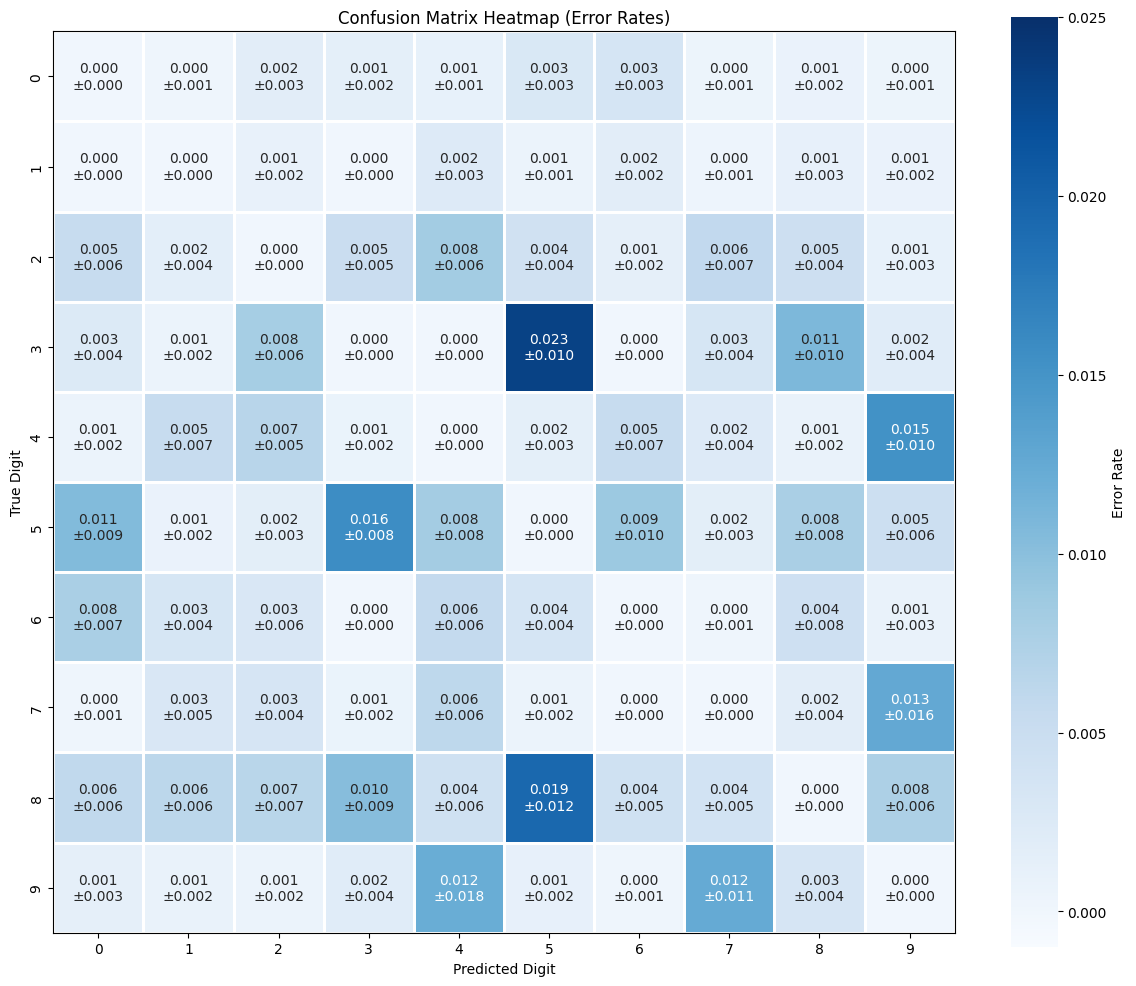

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 10))

annotations = np.empty_like(mean_conf, dtype=object)
for i in range(mean_conf.shape[0]):
    for j in range(mean_conf.shape[1]):
        annotations[i,j] = f'{mean_conf[i,j]:.3f}\n±{std_conf[i,j]:.3f}'

sns.heatmap(mean_conf, 
            annot=annotations,  
            fmt='', 
            cmap=sns.color_palette("Blues", as_cmap=True),
            vmin=-0.001,   
            vmax=0.025,  
            xticklabels=range(10),
            yticklabels=range(10),
            annot_kws={'size': 10},  
            linewidths=1,  
            cbar_kws={'label': 'Error Rate'})


plt.gca().set_box_aspect(1)  
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.title('Confusion Matrix Heatmap (Error Rates)')
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')

plt.tight_layout()
plt.show()

Loading saved analysis results...


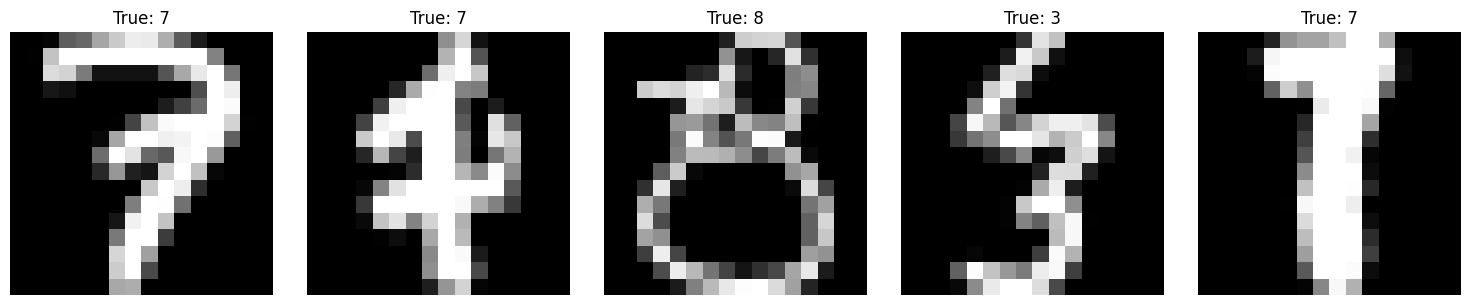


Analysis of consistently misclassified digits:

Digit 1:
True Label: 7
Times Tested: 30
Correct Predictions: 1
Error Rate: 0.97
All predictions: {9: 29, 7: 1}

Digit 2:
True Label: 7
Times Tested: 29
Correct Predictions: 0
Error Rate: 1.00
All predictions: {4: 29}

Digit 3:
True Label: 8
Times Tested: 28
Correct Predictions: 0
Error Rate: 1.00
All predictions: {5: 24, 0: 2, 4: 1, 3: 1}

Digit 4:
True Label: 3
Times Tested: 26
Correct Predictions: 0
Error Rate: 1.00
All predictions: {8: 19, 5: 4, 9: 2, 4: 1}

Digit 5:
True Label: 7
Times Tested: 26
Correct Predictions: 0
Error Rate: 1.00
All predictions: {8: 21, 1: 5}


In [12]:
from collections import Counter
import matplotlib.pyplot as plt

def visualize(X, y, idx):
    """Visualize the hardest-to-classify digits"""
    plt.figure(figsize=(15, 3))
    for i in range(len(idx)):
        plt.subplot(1, len(idx), i+1)
        photo = np.reshape(X[idx[i]], (16, 16))
        plt.imshow(photo, cmap='gray')
        plt.title(f'True: {int(y[idx[i]])}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def train_test_split_with_indices(X, y, train_split, key):
    """Split data while preserving original indices"""
    n_samples = len(X)
    indices = jnp.arange(n_samples)
    
    # Shuffle indices
    key, subkey = random.split(key)
    shuffled_indices = random.permutation(key, indices)
    
    # Split point
    split_idx = int(train_split * n_samples)
    
    # Split data and indices
    train_idx = shuffled_indices[:split_idx]
    test_idx = shuffled_indices[split_idx:]
    
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    return X_train, X_test, y_train, y_test, test_idx

def visualize_and_analyze_errors(X, y, save_file='digit_analysis_results.npy'):
    """Analyze and visualize the hardest-to-classify digits with result caching"""
    
    if os.path.exists(save_file):
        # Load cached results
        saved_data = np.load(save_file, allow_pickle=True).item()
        print("Loading saved analysis results...")
        
        # Visualize the results
        visualize(X, y, saved_data['hardest_indices'])
        
        # Print cached analysis
        print("\nAnalysis of consistently misclassified digits:")
        for i, analysis in enumerate(saved_data['analyses']):
            print(f"\nDigit {i+1}:")
            for key, value in analysis.items():
                print(f"{key}: {value}")
        
        return
    
    # If no cached results, perform the analysis
    if os.path.exists('cross_validation_results.npy'):
        results = np.load('cross_validation_results.npy', allow_pickle=True).item()
        best_d = results['best_d'][0]
        
        # Initialize tracking arrays
        np.random.seed(42)
        errors = np.zeros(len(X))
        total_tests = np.zeros(len(X))
        predictions = [[] for _ in range(len(X))]
        
        # Track errors across multiple runs
        n_runs = 100
        for run in tqdm(range(n_runs)):
            key = random.PRNGKey(run)
            X_train, X_test, y_train, y_test, test_indices = train_test_split_with_indices(X, y, 0.8, key)
            
            y_test_np = np.array(y_test)
            test_indices_np = np.array(test_indices)
            
            clf = MultiKernelPerceptronJAX(X_train, y_train, kernel='p', kernel_param=best_d, epochs=5)
            clf.train()
            y_pred = np.array(clf.predict(X_test))
            
            for i in range(len(X_test)):
                original_idx = test_indices_np[i]
                total_tests[original_idx] += 1
                if y_test_np[i] != y_pred[i]:
                    errors[original_idx] += 1
                predictions[original_idx].append(int(y_pred[i]))
        
        # Get indices and prepare analysis
        hardest_indices = np.argsort(errors)[::-1][:5]
        analyses = []
        
        # Analyze each hard digit
        for i, idx in enumerate(hardest_indices):
            all_preds = Counter(predictions[idx])
            true_label = int(y[idx])
            correct_preds = all_preds.get(true_label, 0)
            total = int(total_tests[idx])
            error_rate = (total - correct_preds) / total if total > 0 else 0
            
            analysis = {
                'True Label': true_label,
                'Times Tested': total,
                'Correct Predictions': correct_preds,
                'Error Rate': f'{error_rate:.2f}',
                'All predictions': dict(all_preds)
            }
            analyses.append(analysis)
        
        # Save results
        save_data = {
            'hardest_indices': hardest_indices,
            'analyses': analyses
        }
        np.save(save_file, save_data)
        
        # Visualize and print
        visualize(X, y, hardest_indices)
        print("\nAnalysis of consistently misclassified digits:")
        for i, analysis in enumerate(analyses):
            print(f"\nDigit {i+1}:")
            for key, value in analysis.items():
                print(f"{key}: {value}")
    else:
        print("No cross validation results file found")

# Run the analysis
visualize_and_analyze_errors(X, y)

In [13]:
# Example usage
train_split = 0.8
c_list = [0.001, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1]
results_file = 'gaussian_basic_results.npy'

# Check if we have saved results
if os.path.exists(results_file):
    saved_results = np.load(results_file, allow_pickle=True).item()
    train_error = saved_results['train_error']
    train_std = saved_results['train_std']
    test_error = saved_results['test_error']
    test_std = saved_results['test_std']
    print("Loaded saved results")
else:
    train_error, train_std, test_error, test_std = [], [], [], []
    key = random.PRNGKey(0)

    for c in c_list:
        single_run_train_errors, single_run_test_errors = [], []
        for run in tqdm(range(20)):
            # Split data
            key, subkey = random.split(key)
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, subkey)
            
            # Train model
            clf = MultiKernelPerceptronJAX(X_train, y_train, kernel='g', kernel_param=c, epochs=5)
            train_e = clf.train()
            test_e = clf.test(X_test, y_test)
            
            single_run_train_errors.append(train_e)
            single_run_test_errors.append(test_e)
        
        # Calculate statistics
        mean_train = jnp.mean(jnp.array(single_run_train_errors))
        std_train = jnp.std(jnp.array(single_run_train_errors))
        mean_test = jnp.mean(jnp.array(single_run_test_errors))
        std_test = jnp.std(jnp.array(single_run_test_errors))
        train_error.append(mean_train)
        train_std.append(std_train)
        test_error.append(mean_test)
        test_std.append(std_test)
        
        print(f'c={c}: Mean Train Error: {mean_train:.2f}, Mean Test Error: {mean_test:.2f}')
    
    # Save results
    np.save(results_file, {
        'train_error': train_error,
        'train_std': train_std,
        'test_error': test_error,
        'test_std': test_std
    })

# Display results
for c, tr_e, tr_s, te_e, te_s in zip(c_list, train_error, train_std, test_error, test_std):
    print(f"c={c}: Train Error = {tr_e:.2f} ± {tr_s:.2f}, Test Error = {te_e:.2f} ± {te_s:.2f}")

Loaded saved results
c=0.001: Train Error = 7.35 ± 0.31, Test Error = 8.17 ± 1.55
c=0.005: Train Error = 1.18 ± 0.12, Test Error = 4.37 ± 1.15
c=0.01: Train Error = 0.39 ± 0.09, Test Error = 3.28 ± 0.39
c=0.015: Train Error = 0.22 ± 0.08, Test Error = 3.22 ± 0.46
c=0.02: Train Error = 0.16 ± 0.05, Test Error = 3.12 ± 0.36
c=0.05: Train Error = 0.05 ± 0.04, Test Error = 3.94 ± 0.32
c=0.1: Train Error = 0.03 ± 0.02, Test Error = 5.14 ± 0.39


In [14]:
from tabulate import tabulate

data = []
for c, tr_e, tr_s, te_e, te_s in zip(c_list, train_error, train_std, test_error, test_std):
    train_result = f"{'{:.4f}'.format(tr_e)}±{'{:.4f}'.format(tr_s)}"
    test_result = f"{'{:.4f}'.format(te_e)}±{'{:.4f}'.format(te_s)}"
    result = [c, train_result, test_result]
    data.append(result)

print(tabulate(data, 
               headers=["c", "Mean Train Error Rates (%)", "Mean Test Error Rates (%)"],
               tablefmt="simple_outline",
               stralign="center"))

┌───────┬──────────────────────────────┬─────────────────────────────┐
│     c │  Mean Train Error Rates (%)  │  Mean Test Error Rates (%)  │
├───────┼──────────────────────────────┼─────────────────────────────┤
│ 0.001 │        7.3501±0.3125         │        8.1667±1.5464        │
│ 0.005 │        1.1831±0.1214         │        4.3683±1.1453        │
│ 0.01  │        0.3872±0.0928         │        3.2796±0.3929        │
│ 0.015 │        0.2212±0.0759         │        3.2231±0.4592        │
│ 0.02  │        0.1566±0.0526         │        3.1210±0.3636        │
│ 0.05  │        0.0497±0.0427         │        3.9409±0.3244        │
│ 0.1   │        0.0282±0.0199         │        5.1371±0.3931        │
└───────┴──────────────────────────────┴─────────────────────────────┘


In [15]:
# Run Gaussian kernel experiment
n_runs = 20
results_file = 'gaussian_cv_results.npy'

# Load previous results if they exist
if os.path.exists(results_file):
    results = np.load(results_file, allow_pickle=True).item()
    start_run = len(results['best_c'])
    print(f"\nCompleted runs:")
    for i in range(start_run):
        print(f"Run {i}: c*={results['best_c'][i]}, train={results['train_error'][i]:.2f}%, test={results['test_error'][i]:.2f}%")
    print(f"\nResuming from run {start_run}")
else:
    results = {
        'best_c': [],
        'train_error': [],
        'test_error': []
    }
    start_run = 0

# Process remaining runs
for run in tqdm(range(start_run, n_runs), desc='Processing runs'):
    try:
        # Clear memory before each run
        gc.collect()
        jax.clear_caches()
        
        best_c, train_error, test_error = cross_validate_single_run(X, y, kernel_type='g')
        results['best_c'].append(best_c)
        results['train_error'].append(train_error)
        results['test_error'].append(test_error)
        
        # Save progress after each run
        np.save(results_file, results)
        
        # Print progress and clear memory
        print(f"Run {run}: c*={best_c}, train={train_error:.2f}%, test={test_error:.2f}%")
        gc.collect()
        jax.clear_caches()
        
    except Exception as e:
        print(f"Error in run {run}: {str(e)}")
        break


Completed runs:
Run 0: c*=0.02, train=0.17%, test=3.12%
Run 1: c*=0.015, train=0.23%, test=3.12%
Run 2: c*=0.015, train=0.32%, test=2.96%
Run 3: c*=0.02, train=0.09%, test=2.69%
Run 4: c*=0.015, train=0.20%, test=3.01%
Run 5: c*=0.015, train=0.19%, test=3.01%
Run 6: c*=0.015, train=0.23%, test=3.23%
Run 7: c*=0.02, train=0.16%, test=3.98%
Run 8: c*=0.02, train=0.20%, test=3.76%
Run 9: c*=0.02, train=0.28%, test=4.73%
Run 10: c*=0.02, train=0.15%, test=3.17%
Run 11: c*=0.02, train=0.16%, test=3.23%
Run 12: c*=0.01, train=0.22%, test=3.66%
Run 13: c*=0.015, train=0.32%, test=3.17%
Run 14: c*=0.02, train=0.19%, test=4.03%
Run 15: c*=0.02, train=0.23%, test=3.12%
Run 16: c*=0.015, train=0.19%, test=3.49%
Run 17: c*=0.015, train=0.22%, test=3.28%
Run 18: c*=0.015, train=0.32%, test=3.55%
Run 19: c*=0.02, train=0.16%, test=3.33%

Resuming from run 20


Processing runs: 0it [00:00, ?it/s]


In [16]:
# Tabulate all results
if os.path.exists('gaussian_cv_results.npy'):
    results = np.load('gaussian_cv_results.npy', allow_pickle=True).item()
    data = []
    for i in range(len(results['best_c'])):
        train_result = f"{'{:.4f}'.format(results['train_error'][i])}"
        test_result = f"{'{:.4f}'.format(results['test_error'][i])}"
        result = [int(i+1), results['best_c'][i], train_result, test_result]
        data.append(result)
    
    # Calculate statistics
    mean_c = np.mean(results['best_c'])
    std_c = np.std(results['best_c'])
    mean_train = np.mean(results['train_error'])
    std_train = np.std(results['train_error'])
    mean_test = np.mean(results['test_error'])
    std_test = np.std(results['test_error'])
    
    # Add a separator line
    data.append(["----", "----", "------------", "------------"])
    
    # Add summary statistics
    data.append(["μ", f"{mean_c:.2f}", f"{mean_train:.4f}", f"{mean_test:.4f}"])
    data.append(["σ", f"{std_c:.2f}", f"{std_train:.4f}", f"{std_test:.4f}"])
    
    print(tabulate(data, 
                  headers=["Run", "c*", "Train Error (%)", "Test Error (%)"],
                  tablefmt="simple_outline",
                  numalign="center",
                  stralign="center"))
else:
    print("No results file found")

┌───────┬───────┬───────────────────┬──────────────────┐
│  Run  │  c*   │  Train Error (%)  │  Test Error (%)  │
├───────┼───────┼───────────────────┼──────────────────┤
│   1   │ 0.02  │      0.1748       │      3.1183      │
│   2   │ 0.015 │      0.2286       │      3.1183      │
│   3   │ 0.015 │      0.3227       │      2.9570      │
│   4   │ 0.02  │      0.0941       │      2.6882      │
│   5   │ 0.015 │      0.2017       │      3.0108      │
│   6   │ 0.015 │      0.1882       │      3.0108      │
│   7   │ 0.015 │      0.2286       │      3.2258      │
│   8   │ 0.02  │      0.1613       │      3.9785      │
│   9   │ 0.02  │      0.2017       │      3.7634      │
│  10   │ 0.02  │      0.2823       │      4.7312      │
│  11   │ 0.02  │      0.1479       │      3.1720      │
│  12   │ 0.02  │      0.1613       │      3.2258      │
│  13   │ 0.01  │      0.2151       │      3.6559      │
│  14   │ 0.015 │      0.3227       │      3.1720      │
│  15   │ 0.02  │      0.1882  

In [17]:
class OneVsOnePerceptron:
    def __init__(self, X, y, kernel='p', kernel_param=2, epochs=5):
        self.X_train = jnp.asarray(X, dtype=jnp.float32)
        self.y_train = jnp.asarray(y, dtype=jnp.int32)
        self.kernel = kernel
        self.kernel_param = kernel_param
        self.epochs = epochs
        self.n_classes = 10
        
        # Create binary classifiers for each pair
        self.classifiers = []
        for i in range(self.n_classes):
            for j in range(i + 1, self.n_classes):
                # Get data for digits i and j
                mask = (self.y_train == i) | (self.y_train == j)
                X_pair = self.X_train[mask]
                y_pair = self.y_train[mask]
                # Convert to binary problem (0 for i, 1 for j)
                y_pair = (y_pair == j).astype(jnp.int32)
                
                # Create binary classifier
                clf = MultiKernelPerceptronJAX(X_pair, y_pair, 
                                             kernel=kernel, 
                                             kernel_param=kernel_param, 
                                             epochs=epochs)
                self.classifiers.append((i, j, clf))
    
    @partial(jax.jit, static_argnums=(0,))
    def _predict_proba(self, X):
        """JIT-compiled prediction"""
        X = jnp.asarray(X, dtype=jnp.float32)
        votes = jnp.zeros((len(X), self.n_classes))
        
        for i, j, clf in self.classifiers:
            predictions = clf.predict(X)
            votes = votes.at[:, j].add(predictions)
            votes = votes.at[:, i].add(1 - predictions)
        
        return votes
    
    def predict(self, X):
        """Predict using voting from all classifiers"""
        votes = self._predict_proba(X)
        return jnp.argmax(votes, axis=1)
    
    def train(self):
        """Train all binary classifiers and return training error"""
        for _, _, clf in self.classifiers:
            clf.train()
        return self.test(self.X_train, self.y_train)
    
    def test(self, X_test, y_test):
        """Compute test error"""
        y_pred = self.predict(X_test)
        return float(jnp.mean(y_pred != y_test) * 100)


In [18]:
# Run Q3 procedure with checkpointing
train_split = 0.8
d_list = range(1, 8)
results_file = 'ovo_polynomial_basic_results.npy'

# Initialize or load existing results
if os.path.exists(results_file):
    saved_results = np.load(results_file, allow_pickle=True).item()
    train_error = saved_results.get('train_error', [])
    train_std = saved_results.get('train_std', [])
    test_error = saved_results.get('test_error', [])
    test_std = saved_results.get('test_std', [])
    completed_d = len(train_error)
    print(f"Loaded saved results for d=1 to {completed_d}")
else:
    train_error, train_std, test_error, test_std = [], [], [], []
    completed_d = 0

# Process remaining d values
key = random.PRNGKey(0)
for d in d_list[completed_d:]:
    print(f"\nProcessing d={d}")
    single_run_train_errors, single_run_test_errors = [], []
    
    for run in tqdm(range(20)):
        # Split data
        key, subkey = random.split(key)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, subkey)
        
        # Train model
        clf = OneVsOnePerceptron(X_train, y_train, kernel='p', kernel_param=d, epochs=5)
        train_e = clf.train()
        test_e = clf.test(X_test, y_test)
        
        single_run_train_errors.append(train_e)
        single_run_test_errors.append(test_e)
    
    # Calculate statistics
    mean_train = jnp.mean(jnp.array(single_run_train_errors))
    std_train = jnp.std(jnp.array(single_run_train_errors))
    mean_test = jnp.mean(jnp.array(single_run_test_errors))
    std_test = jnp.std(jnp.array(single_run_test_errors))
    
    train_error.append(mean_train)
    train_std.append(std_train)
    test_error.append(mean_test)
    test_std.append(std_test)
    
    # Save results after each d
    np.save(results_file, {
        'train_error': train_error,
        'train_std': train_std,
        'test_error': test_error,
        'test_std': test_std
    })

Loaded saved results for d=1 to 7


In [19]:
# Display results table
data = []
for d, tr_e, tr_s, te_e, te_s in zip(d_list, train_error, train_std, test_error, test_std):
    train_result = f"{'{:.4f}'.format(tr_e)}±{'{:.4f}'.format(tr_s)}"
    test_result = f"{'{:.4f}'.format(te_e)}±{'{:.4f}'.format(te_s)}"
    data.append([d, train_result, test_result])

print("\nResults Table:")
print(tabulate(data, 
              headers=["d", "Mean Train Error Rates (%)", "Mean Test Error Rates (%)"],
              tablefmt="simple_outline",
              stralign="center"))


Results Table:
┌─────┬──────────────────────────────┬─────────────────────────────┐
│   d │  Mean Train Error Rates (%)  │  Mean Test Error Rates (%)  │
├─────┼──────────────────────────────┼─────────────────────────────┤
│   1 │        4.0844±0.7428         │        6.7957±0.7964        │
│   2 │        0.6897±0.2263         │        3.9812±0.5479        │
│   3 │        0.1889±0.0861         │        3.4194±0.3584        │
│   4 │        0.0908±0.0747         │        3.2876±0.4411        │
│   5 │        0.0652±0.0458         │        3.3011±0.3871        │
│   6 │        0.0518±0.0585         │        3.5161±0.4899        │
│   7 │        0.0356±0.0266         │        3.5753±0.3564        │
└─────┴──────────────────────────────┴─────────────────────────────┘


In [20]:
import numpy as np
import jax.numpy as jnp
from jax import random
import gc
import jax
import os
from joblib import Parallel, delayed

def cross_validate_single_run(run_id, X, y):
    """Run a single cross-validation run"""
    try:
        # Set different random seed for each run
        key = random.PRNGKey(run_id)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8, key)
        
        best_cv_error = float('inf')
        best_d = 1
        n_folds = 3
        d_errors = {}
        
        # For each d value
        for d in range(1, 8):
            print(f"Run {run_id}, testing d={d}")
            cv_error = 0
            
            # Create fold indices
            indices = jnp.arange(len(X_train))
            key, subkey = random.split(key)
            shuffled_indices = random.permutation(subkey, indices)
            fold_size = len(indices) // n_folds
            
            # For each fold
            for fold in range(n_folds):
                val_idx = shuffled_indices[fold * fold_size:(fold + 1) * fold_size]
                train_idx = jnp.concatenate([
                    shuffled_indices[:fold * fold_size],
                    shuffled_indices[(fold + 1) * fold_size:]
                ])
                
                val_votes = jnp.zeros((len(val_idx), 10))
                
                # Process all pairs
                for i in range(10):
                    for j in range(i + 1, 10):
                        pair_mask = (y_train[train_idx] == i) | (y_train[train_idx] == j)
                        X_pair = X_train[train_idx][pair_mask]
                        y_pair = y_train[train_idx][pair_mask]
                        y_pair = (y_pair == j).astype(jnp.int32)
                        
                        clf = MultiKernelPerceptronJAX(X_pair, y_pair, 
                                                     kernel='p', 
                                                     kernel_param=d, 
                                                     epochs=5)
                        clf.train()
                        val_pred = clf.predict(X_train[val_idx])
                        val_votes = val_votes.at[:, j].add(val_pred)
                        val_votes = val_votes.at[:, i].add(1 - val_pred)
                
                val_pred = jnp.argmax(val_votes, axis=1)
                fold_error = jnp.mean(val_pred != y_train[val_idx]) * 100
                cv_error += float(fold_error)
            
            cv_error /= n_folds
            d_errors[d] = cv_error
            
            if cv_error < best_cv_error:
                best_cv_error = cv_error
                best_d = d
            
            print(f"  d={d}: CV Error = {cv_error:.2f}%")
        
        # Train final model with best d
        final_votes_train = jnp.zeros((len(X_train), 10))
        final_votes_test = jnp.zeros((len(X_test), 10))
        
        for i in range(10):
            for j in range(i + 1, 10):
                pair_mask = (y_train == i) | (y_train == j)
                X_pair = X_train[pair_mask]
                y_pair = y_train[pair_mask]
                y_pair = (y_pair == j).astype(jnp.int32)
                
                clf = MultiKernelPerceptronJAX(X_pair, y_pair, 
                                             kernel='p', 
                                             kernel_param=best_d, 
                                             epochs=5)
                clf.train()
                
                train_pred = clf.predict(X_train)
                test_pred = clf.predict(X_test)
                
                final_votes_train = final_votes_train.at[:, j].add(train_pred)
                final_votes_train = final_votes_train.at[:, i].add(1 - train_pred)
                final_votes_test = final_votes_test.at[:, j].add(test_pred)
                final_votes_test = final_votes_test.at[:, i].add(1 - test_pred)
        
        train_pred = jnp.argmax(final_votes_train, axis=1)
        test_pred = jnp.argmax(final_votes_test, axis=1)
        train_error = float(jnp.mean(train_pred != y_train) * 100)
        test_error = float(jnp.mean(test_pred != y_test) * 100)
        
        return run_id, best_d, train_error, test_error
        
    except Exception as e:
        print(f"Error in run {run_id}: {str(e)}")
        return run_id, None, None, None

if __name__ == '__main__':
    n_runs = 20
    batch_size = 4  # Process 4 runs at a time
    results_file = 'ovo_polynomial_cv_results.npy'

    # Load existing results if any
    if os.path.exists(results_file):
        saved_results = np.load(results_file, allow_pickle=True).item()
        completed_runs = len(saved_results['best_d'])
        print(f"\nCompleted runs: {completed_runs}")
        remaining_runs = list(range(completed_runs, n_runs))
    else:
        saved_results = {'best_d': [], 'train_error': [], 'test_error': []}
        remaining_runs = list(range(n_runs))

    # Process runs in batches of 4
    while remaining_runs:
        # Get next batch of runs
        current_batch = remaining_runs[:batch_size]
        remaining_runs = remaining_runs[batch_size:]

        # Run parallel processing with 4 jobs
        results = Parallel(n_jobs=4)(
            delayed(cross_validate_single_run)(run_id, X, y) 
            for run_id in current_batch
        )
        
        # Process results from this batch
        for run_id, best_d, train_error, test_error in results:
            if best_d is not None:
                saved_results['best_d'].append(best_d)
                saved_results['train_error'].append(train_error)
                saved_results['test_error'].append(test_error)
                
                # Save after each run
                np.save(results_file, saved_results)
                print(f"Run {run_id}: d*={best_d}, train={train_error:.2f}%, test={test_error:.2f}%")
        
        # Print progress
        completed = len(saved_results['best_d'])
        print(f"\nCompleted {completed}/{n_runs} runs")
        print(f"Current mean d*: {np.mean(saved_results['best_d']):.2f}")
        print(f"Current mean test error: {np.mean(saved_results['test_error']):.2f}%")
        print("\nStarting next batch...\n")


Completed runs: 20


In [21]:
# Load and display OvO polynomial kernel results
if os.path.exists('ovo_polynomial_cv_results.npy'):
    results = np.load('ovo_polynomial_cv_results.npy', allow_pickle=True).item()
    
    # Create table data
    data = []
    for i in range(len(results['best_d'])):
        train_result = f"{'{:.4f}'.format(results['train_error'][i])}"
        test_result = f"{'{:.4f}'.format(results['test_error'][i])}"
        result = [int(i+1), results['best_d'][i], train_result, test_result]
        data.append(result)
    
    # Calculate statistics
    mean_d = np.mean(results['best_d'])
    std_d = np.std(results['best_d'])
    mean_train = np.mean(results['train_error'])
    std_train = np.std(results['train_error'])
    mean_test = np.mean(results['test_error'])
    std_test = np.std(results['test_error'])
    
    # Add separator and statistics
    data.append(["----", "----", "------------", "------------"])
    data.append(["μ", f"{mean_d:.2f}", f"{mean_train:.4f}", f"{mean_test:.4f}"])
    data.append(["σ", f"{std_d:.2f}", f"{std_train:.4f}", f"{std_test:.4f}"])
    
    print(tabulate(data, 
                  headers=["Run", "d*", "Train Error (%)", "Test Error (%)"],
                  tablefmt="simple_outline",
                  numalign="center",
                  stralign="center"))
else:
    print("No results file found")

┌───────┬──────┬───────────────────┬──────────────────┐
│  Run  │  d*  │  Train Error (%)  │  Test Error (%)  │
├───────┼──────┼───────────────────┼──────────────────┤
│   1   │  4   │      0.0672       │      2.6882      │
│   2   │  4   │      1.5864       │      4.3548      │
│   3   │  5   │      0.0403       │      3.0108      │
│   4   │  4   │      0.0538       │      3.1720      │
│   5   │  4   │      0.1613       │      3.8172      │
│   6   │  5   │      0.0807       │      3.7097      │
│   7   │  6   │      0.0403       │      3.1183      │
│   8   │  3   │      0.0672       │      2.7419      │
│   9   │  4   │      0.1076       │      3.4409      │
│  10   │  6   │      0.0538       │      3.9247      │
│  11   │  6   │      0.0672       │      3.6559      │
│  12   │  3   │      0.3899       │      4.4086      │
│  13   │  4   │      0.0269       │      3.1183      │
│  14   │  3   │      0.4571       │      4.0323      │
│  15   │  4   │      0.0269       │      3.0645